# Recolección de datos meteorológicos de Chicago
Se ha extraerá el regístro histórico de las temperaturas de Chicago mediante una api de la **[National Oceanic and Atmospheric Administration](https://www.ncdc.noaa.gov/cdo-web/webservices/v2#dataCategories).**

## Parámetros de llamada y respuesta de la Api
**Parámetros de llamada**
* `datasetid`: El id del dataset al que se llama. En este caso se rquiere los resúmenes diarios (*GHCND*)
* `datatype`: Variable que se pide. En este caso temperatura tomada por varias estaciones climáticas (*TOBS*)
* `locarionid`: Id de la ciudad, en este caso se pide Chicago (*CITY:US170006*)
* `startdaye` y `enddate`: Periodo del tiempo por el que se pide el registro, como solo se permite de menos de un año se tendrán que hacer varias llamadas a la Api.
* `limit`: Límite de registros de respuesta, el limite máximo es 1000.
* `units`: Sistema internacional de la temperatura, se usará el sistema métric (*metric*)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date

In [ ]:
mainpath = "/content/drive/MyDrive/Colab Notebooks/BEDU/Datos Análisis del Crimen en Chicago"
filename = "Crimes_2001-2021_clean.csv"
df = pd.read_csv(os.path.join(mainpath, filename), index_col=0)

In [ ]:
df.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,2015-09-05 13:30:00,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,1165074.0,1875917.0,2015,2018-02-10 15:50:01,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,2015-09-04 11:30:00,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,1138875.0,1904869.0,2015,2018-02-10 15:50:01,41.895080,-87.765400,"(41.895080471, -87.765400451)"
3,10224740,HY411595,2015-09-05 12:45:00,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,1152037.0,1920384.0,2015,2018-02-10 15:50:01,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,2015-09-05 13:00:00,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,1141706.0,1900086.0,2015,2018-02-10 15:50:01,41.881903,-87.755121,"(41.881903443, -87.755121152)"
5,10224742,HY411435,2015-09-05 10:55:00,082XX S LOOMIS BLVD,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,614,6.0,21.0,71.0,05,1168430.0,1850165.0,2015,2018-02-10 15:50:01,41.744379,-87.658431,"(41.744378879, -87.658430635)"


In [ ]:
df['Date'] = pd.to_datetime(df.Date)

Se crea una lista de las fechas usadas para `startdate` y `enddate`.

In [ ]:
dates = []
for i in range(20):
  dates.append((f"{2001+i}-01-01",f"{2001+i}-04-01"))
  dates.append((f"{2001+i}-04-01",f"{2001+i}-08-01"))
  dates.append((f"{2001+i}-08-01",f"{2001+i}-12-01"))
  dates.append((f"{2001+i}-12-01",f"{2002+i}-01-01"))
dates

[('2001-01-01', '2001-04-01'),
 ('2001-04-01', '2001-08-01'),
 ('2001-08-01', '2001-12-01'),
 ('2001-12-01', '2002-01-01'),
 ('2002-01-01', '2002-04-01'),
 ('2002-04-01', '2002-08-01'),
 ('2002-08-01', '2002-12-01'),
 ('2002-12-01', '2003-01-01'),
 ('2003-01-01', '2003-04-01'),
 ('2003-04-01', '2003-08-01'),
 ('2003-08-01', '2003-12-01'),
 ('2003-12-01', '2004-01-01'),
 ('2004-01-01', '2004-04-01'),
 ('2004-04-01', '2004-08-01'),
 ('2004-08-01', '2004-12-01'),
 ('2004-12-01', '2005-01-01'),
 ('2005-01-01', '2005-04-01'),
 ('2005-04-01', '2005-08-01'),
 ('2005-08-01', '2005-12-01'),
 ('2005-12-01', '2006-01-01'),
 ('2006-01-01', '2006-04-01'),
 ('2006-04-01', '2006-08-01'),
 ('2006-08-01', '2006-12-01'),
 ('2006-12-01', '2007-01-01'),
 ('2007-01-01', '2007-04-01'),
 ('2007-04-01', '2007-08-01'),
 ('2007-08-01', '2007-12-01'),
 ('2007-12-01', '2008-01-01'),
 ('2008-01-01', '2008-04-01'),
 ('2008-04-01', '2008-08-01'),
 ('2008-08-01', '2008-12-01'),
 ('2008-12-01', '2009-01-01'),
 ('2009-

In [ ]:
dates = dates + [("2021-01-01","2021-04-18")]

In [ ]:
len(dates)

81

In [ ]:
Se crea una función que realiza la llamada a la Api y devuelve la lista de los regístros.

In [ ]:
def get_temp (start_date, end_date, i = 0):
  import requests
  import time
  import json
  url = f"https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TOBS&locationid=CITY:US170006&startdate={start_date}&enddate={end_date}&limit=1000&units=metric"
  keys = ["VGDFpmAjvjmRAmKeaFRkwxtMIbPfpTje","WWwPiFGLWsSDvoUzNBUZWcfuOndqSLeZ","hOOWnDUWaUvgKvxARAdTOYODHSGkDTkI","JYfqQBpiduegkObltJEoknxhZhhsnLbR","lXnaXOoVmcwuRrowYZEerCWWDjrcgwxG","geUKvlTNGsYHcYXBftIIddAYnnlCFFWS","YoNPimEmuMSZmAxdqkxqiIwjQRErMVUn","bxrtXMkWzaQUWBxdgzMkKAgQsuIuzRPe"]
  payload={}
  headers = {
    'token': keys[i%len(keys)]
  }
  start = time.time()
  response = requests.request("GET", url, headers=headers, data=payload)
  end = time.time()
  temp = []
  if (response.status_code == 200 and response.text != "{}"):
    json_data = json.loads(response.text)
    temp = json_data["results"]
    print(f"\r{i}\t\t{start_date} - {end_date}\t\t{end-start}", end = "")
    if json_data["metadata"]["resultset"]["count"] > 1000:
      print (f"Limite excedido{start_date}-{end_date}    Codigo{response.status_code}")
  else:
    print (f"Error Fecha{start_date}-{end_date}    Codigo{response.status_code}")
  time.sleep(0.2)
  return temp

Se hace un ciclo for para hacer las peticiones de cada fecha necesaria. Se hace también un registro de errores para volver a hacer otra petición disminuyendo el tamaño del periodo de tiempo pedido.

In [ ]:
i = 0
data_list = []
for date in dates:
  data_td = get_temp(date[0],date[1],i)
  i = i+1
  data_list = data_list + data_td

41		2011-04-01 - 2011-08-01		1.7392470836639404Limite excedido2011-04-01-2011-08-01    Codigo200
67		2017-12-01 - 2018-01-01		14.946911096572876Error Fecha2018-01-01-2018-04-01    Codigo503
82		2011-06-01 - 2011-08-01		1.3437387943267822

In [ ]:
dates_extra = []
dates_extra.append(("2011-04-01","2011-06-01"))
dates_extra.append(("2011-06-01","2011-08-01"))
dates_extra.append(("2018-01-01","2018-02-01"))
dates_extra.append(("2018-02-01","2018-04-01"))

In [ ]:
for date in dates_extra:
  data_td = get_temp(date[0],date[1],i)
  i = i+1
  data_list = data_list + data_td

84		2018-02-01 - 2018-04-01		11.11660099029541

In [ ]:
data_copy = data_list

In [ ]:
data_api = pd.DataFrame(data_copy)
data_api.tail(10)

,date,datatype,station,attributes,value
57456,2018-03-31T00:00:00,TOBS,GHCND:USC00116616,",,7,0800",2.2
57457,2018-03-31T00:00:00,TOBS,GHCND:USC00117457,",,7,2400",-0.6
57458,2018-04-01T00:00:00,TOBS,GHCND:USC00110442,",,7,0800",-5.0
57459,2018-04-01T00:00:00,TOBS,GHCND:USC00111497,",,7,0800",-3.9
57460,2018-04-01T00:00:00,TOBS,GHCND:USC00111550,",,7,2400",-1.7
57461,2018-04-01T00:00:00,TOBS,GHCND:USC00111577,",,7,2400",-3.3
57462,2018-04-01T00:00:00,TOBS,GHCND:USC00115097,",,7,0700",-2.2
57463,2018-04-01T00:00:00,TOBS,GHCND:USC00115110,",,7,",3.9
57464,2018-04-01T00:00:00,TOBS,GHCND:USC00116616,",,7,0800",-2.2
57465,2018-04-01T00:00:00,TOBS,GHCND:USC00117457,",,7,2400",-5.6


In [ ]:
data_api["date"] = data_api["date"].apply(lambda x: x[:10])
data_api.sample(5)

,date,datatype,station,attributes,value
17347,2007-07-11,TOBS,GHCND:USC00111497,",,0,0800",17.8
35757,2013-12-15,TOBS,GHCND:USC00117457,",,7,2400",-11.1
38997,2015-01-24,TOBS,GHCND:USC00111577,",,7,2400",1.7
36418,2014-03-09,TOBS,GHCND:USC00117457,",,7,2400",3.3
31562,2012-05-14,TOBS,GHCND:USC00111497,",,7,0800",16.7


In [ ]:
data_api["date"] = pd.to_datetime(data_api.date)
data_api.sample(5)

,date,datatype,station,attributes,value
51335,2019-07-22,TOBS,GHCND:USC00111577,",,7,2400",17.2
43195,2016-07-05,TOBS,GHCND:USC00111550,",,7,2400",25.0
2586,2002-01-01,TOBS,GHCND:USC00118324,",,0,0700",-13.3
54783,2020-12-06,TOBS,GHCND:USC00116616,",,7,0800",0.0
16834,2007-04-29,TOBS,GHCND:USC00117457,",,0,2400",19.4


In [ ]:
data_api.dtypes

date          datetime64[ns]
datatype              object
station               object
attributes            object
value                float64
dtype: object

In [ ]:
#df_grouped_day = df_days.groupby("Day")["Total"].count()
data_api_grouped = data_api.groupby("date")["value"].mean()
data_api_grouped.head(10)

date
2001-01-01   -10.871429
2001-01-02   -13.257143
2001-01-03    -6.585714
2001-01-04    -4.757143
2001-01-05    -2.300000
2001-01-06    -4.757143
2001-01-07    -2.071429
2001-01-08    -8.471429
2001-01-09    -9.900000
2001-01-10    -5.000000
Name: value, dtype: float64

In [ ]:
len(data_api_grouped)

7413

In [ ]:
df_grouped_day = pd.DataFrame({"Date":df_grouped_day.index,"Total_Crimes":df_grouped_day.values})
df_grouped_day

,Date,Total_Crimes
0,2001-01-01,274
1,2001-01-02,10
2,2001-01-03,4
3,2001-01-05,6
4,2001-01-06,6
...,...,...
7405,2021-04-14,434
7406,2021-04-15,443
7407,2021-04-16,458
7408,2021-04-17,474


In [ ]:
#df_grouped_day = pd.DataFrame({"Date":df_grouped_day.index,"Total_Crimes":df_grouped_day.values})
df_api = pd.DataFrame({"Date":data_api_grouped.index,"Temperature":data_api_grouped.values})
df_api

,Date,Temperature
0,2001-01-01,-10.871429
1,2001-01-02,-13.257143
2,2001-01-03,-6.585714
3,2001-01-04,-4.757143
4,2001-01-05,-2.300000
...,...,...
7408,2021-04-14,4.183333
7409,2021-04-15,5.142857
7410,2021-04-16,4.500000
7411,2021-04-17,4.028571


In [ ]:
df_grouped_day

,Date,Total_Crimes
0,2001-01-01,274
1,2001-01-02,10
2,2001-01-03,4
3,2001-01-05,6
4,2001-01-06,6
...,...,...
7405,2021-04-14,434
7406,2021-04-15,443
7407,2021-04-16,458
7408,2021-04-17,474


In [ ]:
df_api["Date"] = df_api["Date"].apply(lambda x: str(x.date()))

In [ ]:
df_grouped_day["Date"] = df_grouped_day["Date"].apply(lambda x: str(x))

## Union de datos de temperatura con crimenes por día

In [ ]:
df_crimes_temperatures = pd.merge(df_grouped_day, df_api, how = "inner", on = "Date")
df_crimes_temperatures

,Date,Total_Crimes,Temperature
0,2001-01-01,274,-10.871429
1,2001-01-02,10,-13.257143
2,2001-01-03,4,-6.585714
3,2001-01-05,6,-2.300000
4,2001-01-06,6,-4.757143
...,...,...,...
7405,2021-04-14,434,4.183333
7406,2021-04-15,443,5.142857
7407,2021-04-16,458,4.500000
7408,2021-04-17,474,4.028571


In [121]:
df_crimes_temperatures

,Date,Total_Crimes,Temperature
0,2001-01-01,274,-10.871429
1,2001-01-02,10,-13.257143
2,2001-01-03,4,-6.585714
3,2001-01-05,6,-2.300000
4,2001-01-06,6,-4.757143
...,...,...,...
7405,2021-04-14,434,4.183333
7406,2021-04-15,443,5.142857
7407,2021-04-16,458,4.500000
7408,2021-04-17,474,4.028571


In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

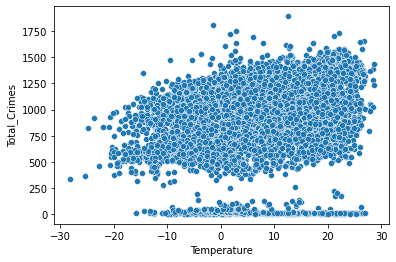

In [124]:
sns.scatterplot(df_crimes_temperatures["Temperature"], df_crimes_temperatures["Total_Crimes"])

In [ ]:
df_crimes_temperatures.to_csv(os.path.join(mainpath,"Chicago_Weather_Crimes.csv"))